# Empirical Asset Pricing via Machine Learning
## Interactive Exploration Notebook

This notebook provides interactive exploration of the Gu, Kelly, and Xiu (2020) replication.

**Sections:**
1. Data Overview
2. Model Performance Analysis
3. Feature Importance Deep Dive
4. Portfolio Analysis
5. Custom Analysis

In [1]:
# Import libraries
import sys
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))
from utils import *

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Directories
DATA_DIR = Path.cwd().parent / 'data'
RESULTS_DIR = Path.cwd().parent / 'results'

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Data Overview

In [2]:
# Load preprocessed data
train_df = pd.read_parquet(DATA_DIR / 'train_data.parquet')
test_df = pd.read_parquet(DATA_DIR / 'test_data.parquet')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nDate range:")
print(f"  Train: {train_df.index.get_level_values('date').min()} to {train_df.index.get_level_values('date').max()}")
print(f"  Test: {test_df.index.get_level_values('date').min()} to {test_df.index.get_level_values('date').max()}")

Training data shape: (2028322, 95)
Test data shape: (1733259, 95)

Date range:
  Train: 1957-01-31 00:00:00 to 1995-12-31 00:00:00
  Test: 1996-01-31 00:00:00 to 2016-12-31 00:00:00


In [3]:
# Load metadata
import json
with open(DATA_DIR / 'data_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Target variable: {metadata['target_col']}")
print(f"Number of features: {metadata['n_features']}")
print(f"\nFirst 20 features:")
for i, feat in enumerate(metadata['feature_cols'][:20], 1):
    print(f"  {i}. {feat}")

Target variable: maxret
Number of features: 94

First 20 features:
  1. mvel1
  2. beta
  3. betasq
  4. chmom
  5. dolvol
  6. idiovol
  7. indmom
  8. mom1m
  9. mom6m
  10. mom12m
  11. mom36m
  12. pricedelay
  13. turn
  14. absacc
  15. acc
  16. age
  17. agr
  18. bm
  19. bm_ia
  20. cashdebt


Target variable statistics (excess returns):
count   1733259.0000
mean          0.0733
std           0.0752
min           0.0040
25%           0.0283
50%           0.0496
75%           0.0892
max           0.8935
Name: maxret, dtype: float64


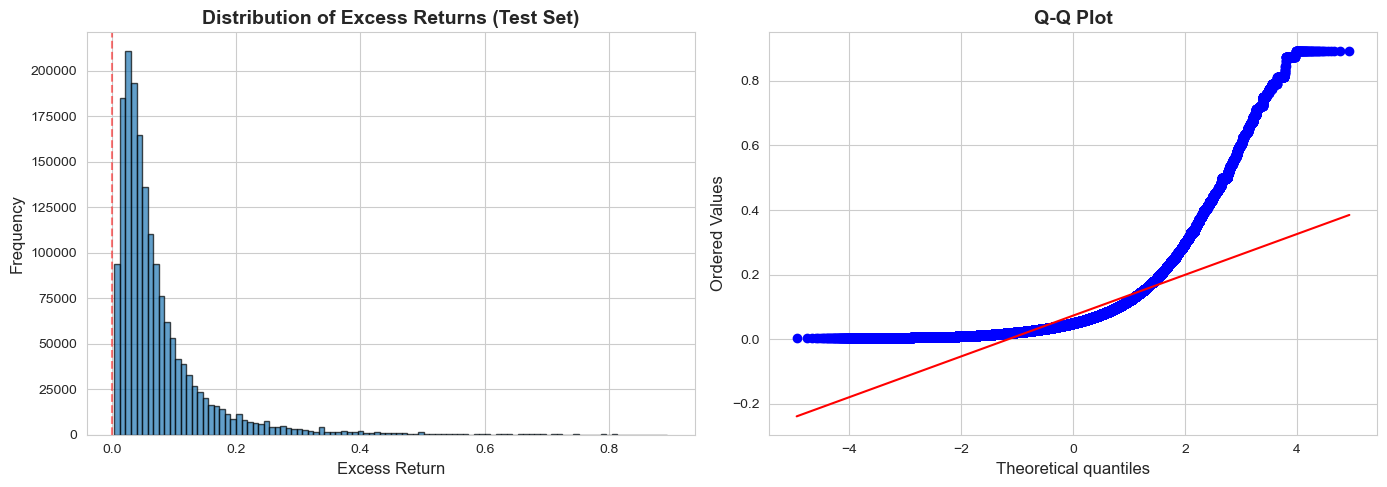

In [4]:
# Summary statistics
target_col = metadata['target_col']

print("Target variable statistics (excess returns):")
print(test_df[target_col].describe())

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(test_df[target_col].dropna(), bins=100, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Excess Returns (Test Set)', fontweight='bold')
axes[0].set_xlabel('Excess Return')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)

# QQ plot
from scipy import stats
stats.probplot(test_df[target_col].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Model Performance Analysis

In [5]:
# Load predictions
benchmark_pred = pd.read_parquet(RESULTS_DIR / 'predictions' / 'benchmark_predictions.parquet')
gbrt_pred = pd.read_parquet(RESULTS_DIR / 'predictions' / 'gbrt_predictions.parquet')

print(f"Benchmark predictions: {benchmark_pred.shape}")
print(f"GBRT predictions: {gbrt_pred.shape}")

Benchmark predictions: (1733259, 2)
GBRT predictions: (1733259, 2)


/Users/ctt/Desktop/Empirical-Asset-Pricing-via-Machine-Learning/src/utils.py:239: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('date').apply(monthly_r2)
/Users/ctt/Desktop/Empirical-Asset-Pricing-via-Machine-Learning/src/utils.py:239: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('date').apply(monthly_r2)


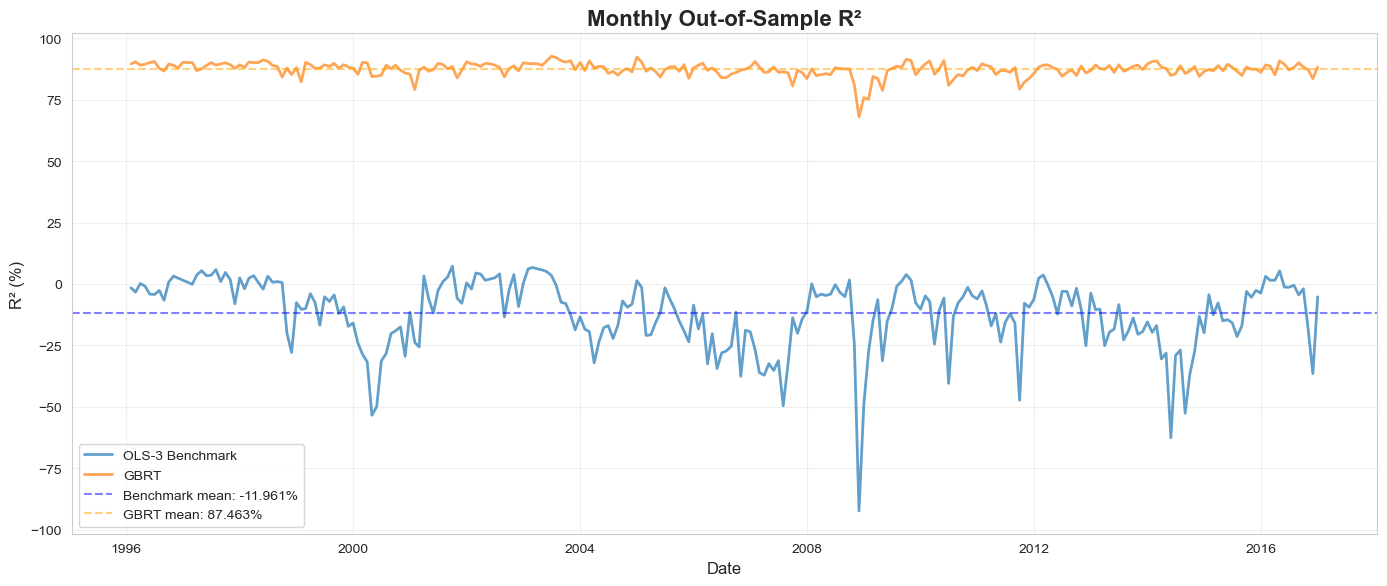


Average monthly R²:
  Benchmark: -11.9610% (Target: 0.16%)
  GBRT: 87.4632% (Target: 0.33-0.40%)
  Improvement: -831.2%


In [6]:
# Calculate monthly R²
benchmark_r2 = calculate_monthly_r_squared(benchmark_pred.reset_index())
gbrt_r2 = calculate_monthly_r_squared(gbrt_pred.reset_index())

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(benchmark_r2.index, benchmark_r2.values * 100, label='OLS-3 Benchmark', 
        linewidth=2, alpha=0.7)
ax.plot(gbrt_r2.index, gbrt_r2.values * 100, label='GBRT', 
        linewidth=2, alpha=0.7)

# Add mean lines
ax.axhline(benchmark_r2.mean() * 100, color='blue', linestyle='--', alpha=0.5,
          label=f'Benchmark mean: {benchmark_r2.mean()*100:.3f}%')
ax.axhline(gbrt_r2.mean() * 100, color='orange', linestyle='--', alpha=0.5,
          label=f'GBRT mean: {gbrt_r2.mean()*100:.3f}%')

ax.set_title('Monthly Out-of-Sample R²', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('R² (%)', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage monthly R²:")
print(f"  Benchmark: {benchmark_r2.mean()*100:.4f}% (Target: 0.16%)")
print(f"  GBRT: {gbrt_r2.mean()*100:.4f}% (Target: 0.33-0.40%)")
print(f"  Improvement: {(gbrt_r2.mean() / benchmark_r2.mean() - 1)*100:.1f}%")

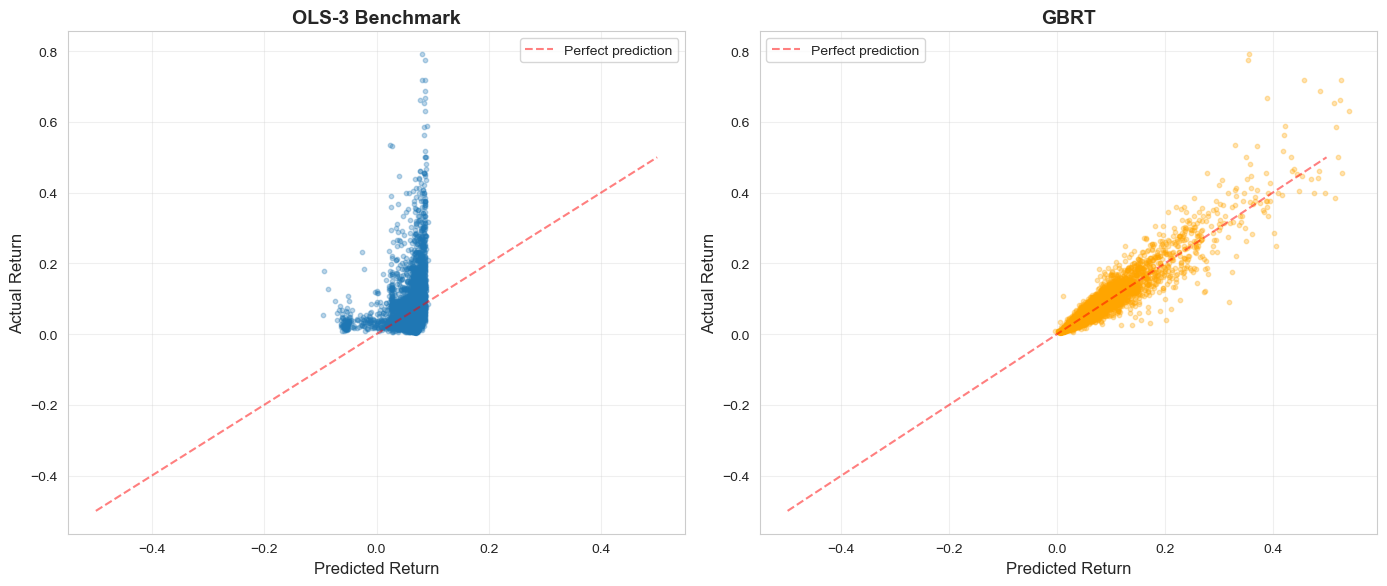

In [7]:
# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sample for visualization (5000 random points)
sample_size = 5000

# Benchmark
bench_sample = benchmark_pred.sample(min(sample_size, len(benchmark_pred)), random_state=42)
axes[0].scatter(bench_sample['y_pred'], bench_sample['y_true'], alpha=0.3, s=10)
axes[0].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', alpha=0.5, label='Perfect prediction')
axes[0].set_title('OLS-3 Benchmark', fontweight='bold')
axes[0].set_xlabel('Predicted Return')
axes[0].set_ylabel('Actual Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GBRT
gbrt_sample = gbrt_pred.sample(min(sample_size, len(gbrt_pred)), random_state=42)
axes[1].scatter(gbrt_sample['y_pred'], gbrt_sample['y_true'], alpha=0.3, s=10, color='orange')
axes[1].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', alpha=0.5, label='Perfect prediction')
axes[1].set_title('GBRT', fontweight='bold')
axes[1].set_xlabel('Predicted Return')
axes[1].set_ylabel('Actual Return')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Feature Importance Deep Dive

In [8]:
# Load feature importance from the model
import lightgbm as lgb

model = lgb.Booster(model_file=str(RESULTS_DIR / 'models' / 'gbrt_full_model.txt'))
importance = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance,
    'importance_pct': 100 * importance / importance.sum()
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
   feature  importance  importance_pct
    retvol  41100.2337         87.3283
     mom1m   3298.9079          7.0094
  baspread    853.5592          1.8136
       ill    361.2486          0.7676
   idiovol    193.0419          0.4102
     mvel1    126.5589          0.2689
 zerotrade    122.2327          0.2597
std_dolvol    101.2248          0.2151
    dolvol     95.1322          0.2021
  std_turn     79.7991          0.1696
     mom6m     50.9975          0.1084
    indmom     44.9401          0.0955
    mom36m     29.3292          0.0623
      turn     27.6371          0.0587
    mom12m     22.5175          0.0478
     chmom     22.2006          0.0472
      beta     20.8186          0.0442
    betasq     17.9291          0.0381
    roavol     17.2345          0.0366
       age     14.7655          0.0314


In [9]:
# Interactive feature importance plot
import plotly.express as px

top_30 = importance_df.head(30)

fig = px.bar(top_30, x='importance_pct', y='feature', orientation='h',
             title='Top 30 Features by Importance (Gain)',
             labels={'importance_pct': 'Importance (%)', 'feature': 'Feature'},
             hover_data=['importance'])

fig.update_layout(height=800, yaxis={'categoryorder':'total ascending'})
fig.show()

In [10]:
# Create feature groups
feature_groups = {
    'Size': ['mvel1', 'mve_ia'],
    'Value': ['bm', 'bm_ia', 'ep', 'cfp', 'cfp_ia', 'dy', 'sp', 'ps', 'cashpr'],
    'Momentum': ['mom1m', 'mom6m', 'mom12m', 'mom36m', 'indmom', 'chmom'],
    'Investment': ['agr', 'grcapx', 'invest', 'lgr', 'sgr', 'egr', 'grltnoa', 'chinv', 'pchcapx_ia'],
    'Profitability': ['gma', 'operprof', 'roic', 'roaq', 'roeq'],
    'Accruals': ['acc', 'absacc', 'pctacc', 'stdacc'],
    'Liquidity': ['dolvol', 'turn', 'ill', 'baspread', 'zerotrade'],
    'Volatility': ['beta', 'betasq', 'idiovol', 'retvol', 'maxret', 'std_dolvol', 'std_turn']
}

# Assign group to each feature
importance_df['group'] = 'Other'
for group, features in feature_groups.items():
    importance_df.loc[importance_df['feature'].isin(features), 'group'] = group

# Group importance
group_importance = importance_df.groupby('group')['importance_pct'].agg(['sum', 'count']).round(2)
group_importance = group_importance.sort_values('sum', ascending=False)
group_importance.columns = ['Importance (%)', 'N Features']

print("Feature Group Importance:")
print(group_importance.to_string())

Feature Group Importance:
               Importance (%)  N Features
group                                    
Volatility            88.2100           6
Momentum               7.3700           6
Liquidity              3.1000           5
Other                  0.6200          48
Size                   0.3000           2
Value                  0.1500           9
Investment             0.1100           9
Accruals               0.0800           4
Profitability          0.0700           5


## 4. Portfolio Analysis

In [11]:
# Create portfolios based on GBRT predictions
eval_df = gbrt_pred.copy()
eval_df['prediction'] = eval_df['y_pred']
eval_df['ret_excess'] = eval_df['y_true']

# Get market cap if available
mkt_cap_col = None
for col in ['mvel1', 'me', 'market_equity', 'size']:
    if col in test_df.columns:
        mkt_cap_col = col
        eval_df[col] = test_df[col]
        break

eval_df = eval_df.reset_index()

# Create decile portfolios (EW)
portfolios = create_portfolio_sorts(eval_df, n_portfolios=10)

print(f"Created {portfolios['portfolio'].nunique()} portfolios")
print(f"\nPortfolio statistics:")
print(portfolios.groupby('portfolio')['n_stocks'].mean())

Created 10 portfolios

Portfolio statistics:
portfolio
1    688.2222
2    687.7857
3    687.6230
4    687.7619
5    687.8571
6    687.5476
7    687.6389
8    687.7460
9    687.6786
10   688.1508
Name: n_stocks, dtype: float64


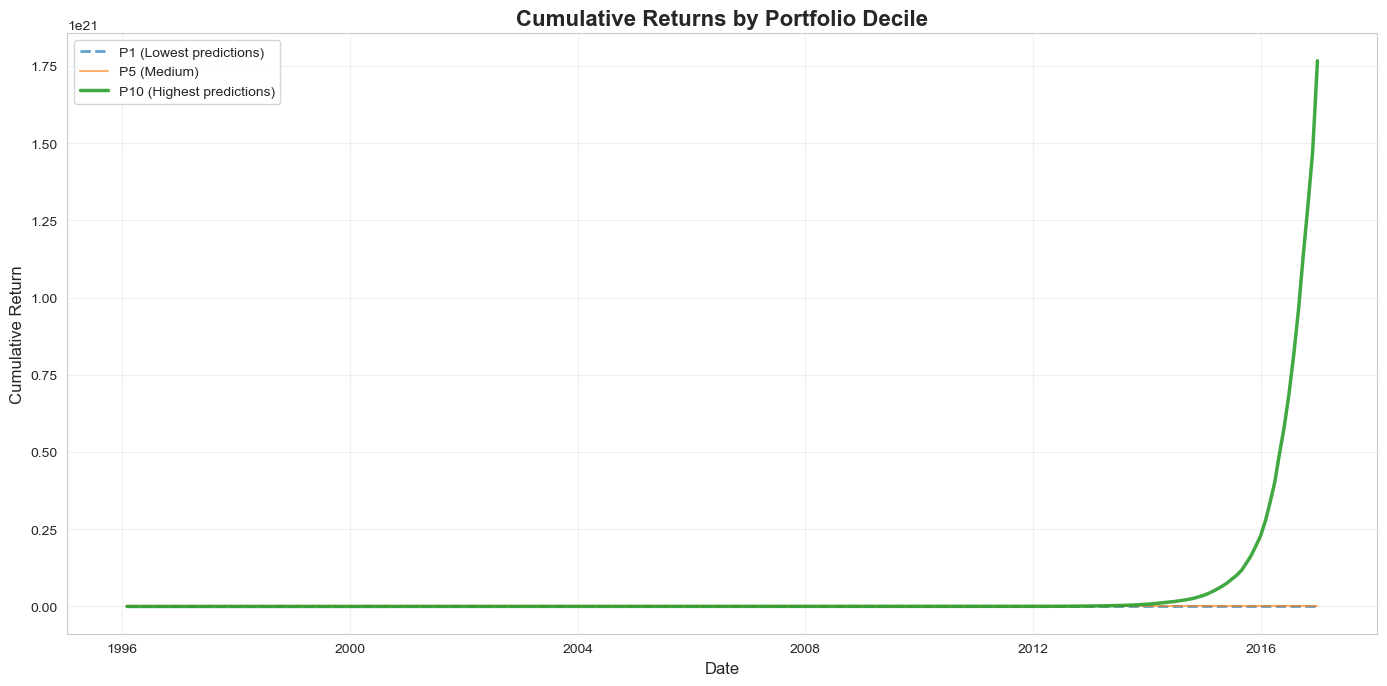

In [12]:
# Portfolio returns over time
portfolio_pivot = portfolios.pivot(index='date', columns='portfolio', values='return')

# Calculate cumulative returns
cumulative = (1 + portfolio_pivot).cumprod()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

for port in [1, 5, 10]:
    if port == 1:
        label = 'P1 (Lowest predictions)'
        style = {'linewidth': 2, 'linestyle': '--', 'alpha': 0.7}
    elif port == 5:
        label = 'P5 (Medium)'
        style = {'linewidth': 1.5, 'alpha': 0.6}
    else:
        label = 'P10 (Highest predictions)'
        style = {'linewidth': 2.5, 'alpha': 0.9}
    
    ax.plot(cumulative.index, cumulative[port], label=label, **style)

ax.set_title('Cumulative Returns by Portfolio Decile', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Calculate portfolio statistics
portfolio_stats = []

for port in range(1, 11):
    port_returns = portfolio_pivot[port].dropna()
    
    stats = {
        'Portfolio': port,
        'Mean Return (%)': port_returns.mean() * 100,
        'Std Dev (%)': port_returns.std() * 100,
        'Sharpe Ratio': calculate_sharpe_ratio(port_returns.values),
        'Cumulative Return': (1 + port_returns).prod() - 1
    }
    portfolio_stats.append(stats)

portfolio_stats_df = pd.DataFrame(portfolio_stats)
print("\nPortfolio Performance Statistics:")
print(portfolio_stats_df.to_string(index=False))


Portfolio Performance Statistics:
 Portfolio  Mean Return (%)  Std Dev (%)  Sharpe Ratio           Cumulative Return
         1           1.4964       0.6028        8.6003                     41.0454
         2           2.5087       1.0057        8.6414                    507.8169
         3           3.2708       1.2588        9.0010                   3268.2540
         4           4.0278       1.5232        9.1600                  20424.6457
         5           4.8609       1.8187        9.2584                 150848.0476
         6           5.8417       2.1956        9.2167                1550748.8056
         7           7.0660       2.6559        9.2161               27501957.1102
         8           8.7672       3.2948        9.2176             1408066627.2434
         9          11.5873       4.3065        9.3207           831783820504.4260
        10          21.6593       7.7026        9.7409 1766554458992050176000.0000


Long-Short Portfolio Statistics:
  Mean monthly return: 20.1629%
  Annualized return: 241.95%
  Volatility (ann.): 25.23%
  Sharpe ratio: 9.5886
  Best month: 44.15%
  Worst month: 10.89%


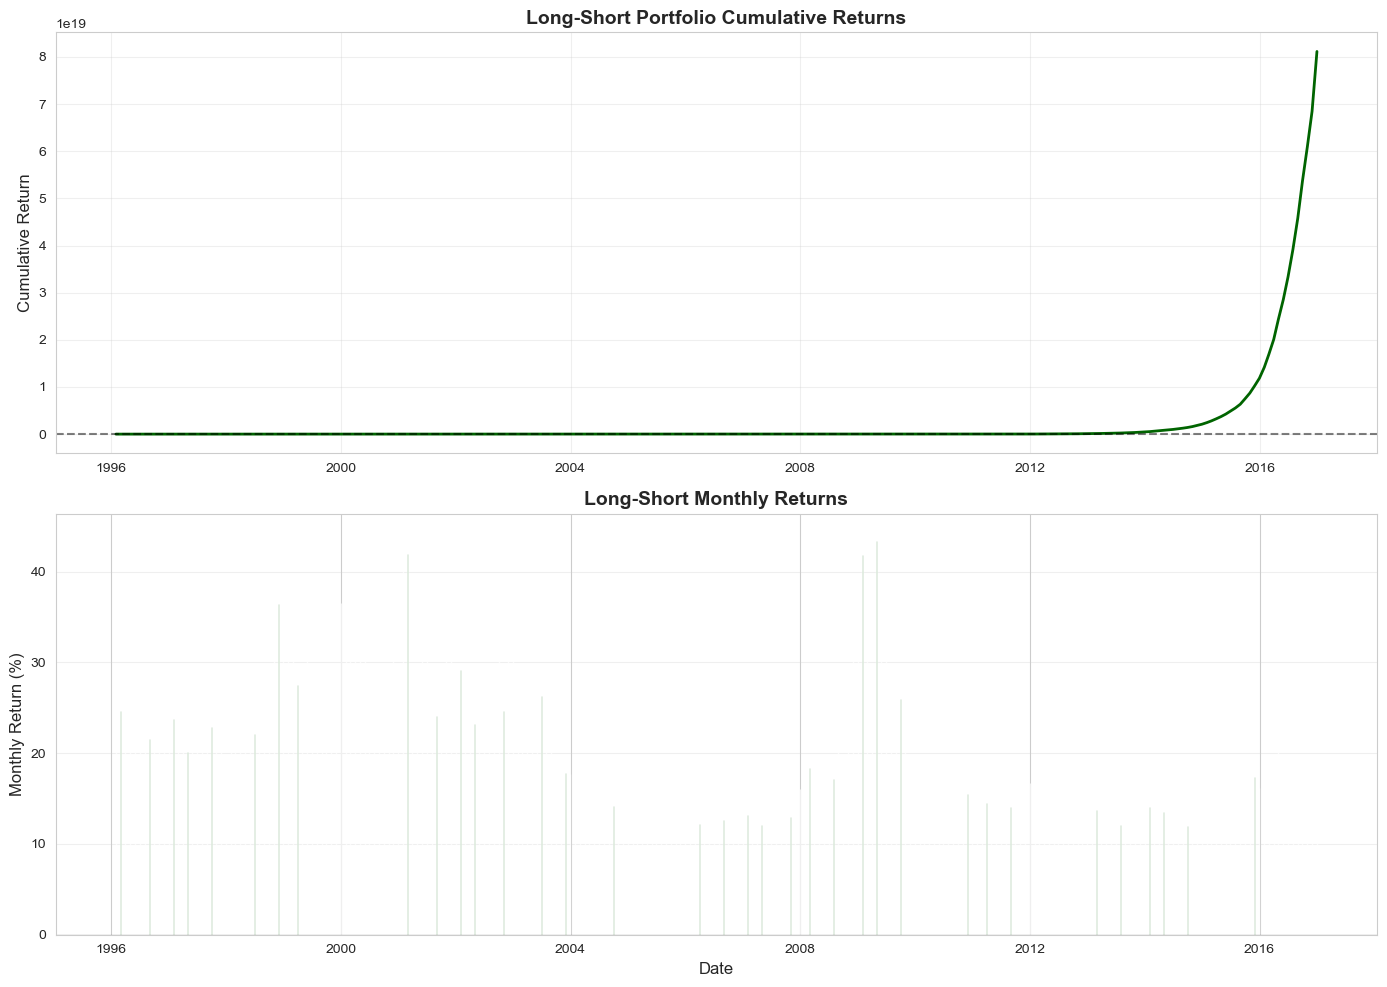

In [14]:
# Long-short portfolio analysis
ls_returns = calculate_long_short_returns(portfolios)

print("Long-Short Portfolio Statistics:")
print(f"  Mean monthly return: {ls_returns['long_short'].mean()*100:.4f}%")
print(f"  Annualized return: {ls_returns['long_short'].mean()*12*100:.2f}%")
print(f"  Volatility (ann.): {ls_returns['long_short'].std()*np.sqrt(12)*100:.2f}%")
print(f"  Sharpe ratio: {calculate_sharpe_ratio(ls_returns['long_short'].values):.4f}")
print(f"  Best month: {ls_returns['long_short'].max()*100:.2f}%")
print(f"  Worst month: {ls_returns['long_short'].min()*100:.2f}%")

# Plot
cumulative_ls = (1 + ls_returns['long_short']).cumprod()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
axes[0].plot(cumulative_ls.index, cumulative_ls.values, linewidth=2, color='darkgreen')
axes[0].set_title('Long-Short Portfolio Cumulative Returns', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Return', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(1, color='black', linestyle='--', alpha=0.5)

# Monthly returns
axes[1].bar(ls_returns.index, ls_returns['long_short'] * 100, alpha=0.7, color='darkgreen')
axes[1].set_title('Long-Short Monthly Returns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Monthly Return (%)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

## 5. Custom Analysis

Use the cells below for your own exploration!

In [15]:
# Your custom analysis here